In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
# useful additional packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit.optimization.applications.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SPSA,COBYLA
from qiskit.aqua import aqua_globals
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

/opt/conda/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/opt/conda/lib/python3.8/site-packages/qiskit/optimization/__init__.py:92: DeprecationWarning: The package qiskit.optimization is deprecated. It was moved/refactored to qiskit_optimization (pip install qiskit-optimization). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('optimization', 'qiskit_optimization', 'qiskit-optimization')


/opt/conda/lib/python3.8/site-packages/qiskit/optimization/applications/ising/tsp.py:67: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  aqua_globals.random_seed = seed


distance
 [[ 0. 48. 91. 33.]
 [48.  0. 63. 71.]
 [91. 63.  0. 92.]
 [33. 71. 92.  0.]]


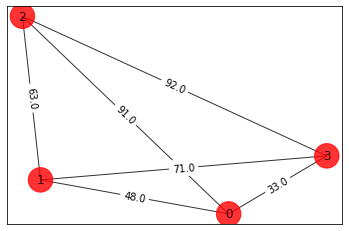

In [3]:
# Generating a graph of 4 nodes
n = 4
num_qubits = n ** 2
ins = tsp.random_tsp(n, seed=123)
print('distance\n', ins.w)

# Draw the graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, ins.dim, 1))
colors = ['r' for node in G.nodes()]

for i in range(0, ins.dim):
    for j in range(i+1, ins.dim):
        G.add_edge(i, j, weight=ins.w[i,j])

pos = {k: v for k, v in enumerate(ins.coord)}
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
draw_graph(G, colors, pos)

order = (0, 1, 2, 3) Distance = 236.0
Best order from brute force = (0, 1, 2, 3) with total distance = 236.0


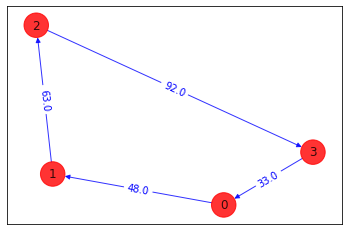

In [4]:
#brute force method
from itertools import permutations

def brute_force_tsp(w, N):
    a=list(permutations(range(1,N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j,pre_j]
            pre_j = j
        distance = distance + w[pre_j,0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print('order = ' + str(order) + ' Distance = ' + str(distance))
    return last_best_distance, best_order

best_distance, best_order = brute_force_tsp(ins.w, ins.dim)
print('Best order from brute force = ' + str(best_order) + ' with total distance = ' + str(best_distance))

def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]['weight'])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2, node_color=colors, edge_color='b', node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G2, 'weight')
    nx.draw_networkx_edge_labels(G2, pos, font_color='b', edge_labels=edge_labels)

draw_tsp_solution(G, best_order, colors, pos)


In [5]:
#getting the hamiltonian
qubitOp, offset = tsp.get_operator(ins)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(qubitOp.print_details())

Offset: 1600796.0
Ising Hamiltonian:
IIIIIIIIIIIIIIIZ	(-200086+0j)
IIIIIIIIIIZIIIII	(-200091+0j)
IIIIIIIIIIZIIIIZ	(12+0j)
IIIIIIIIIIIIIIZI	(-200086+0j)
IIIIIIIIIZIIIIII	(-200091+0j)
IIIIIIIIIZIIIIZI	(12+0j)
IIIIIIIIIIIIIZII	(-200086+0j)
IIIIIIIIZIIIIIII	(-200091+0j)
IIIIIIIIZIIIIZII	(12+0j)
IIIIIIIIIIIIZIII	(-200086+0j)
IIIIIIIIIIIZIIII	(-200091+0j)
IIIIIIIIIIIZZIII	(12+0j)
IIIIIIZIIIIIIIII	(-200123+0j)
IIIIIIZIIIIIIIIZ	(22.75+0j)
IIIIIZIIIIIIIIII	(-200123+0j)
IIIIIZIIIIIIIIZI	(22.75+0j)
IIIIZIIIIIIIIIII	(-200123+0j)
IIIIZIIIIIIIIZII	(22.75+0j)
IIIIIIIZIIIIIIII	(-200123+0j)
IIIIIIIZIIIIZIII	(22.75+0j)
IIZIIIIIIIIIIIII	(-200098+0j)
IIZIIIIIIIIIIIIZ	(8.25+0j)
IZIIIIIIIIIIIIII	(-200098+0j)
IZIIIIIIIIIIIIZI	(8.25+0j)
ZIIIIIIIIIIIIIII	(-200098+0j)
ZIIIIIIIIIIIIZII	(8.25+0j)
IIIZIIIIIIIIIIII	(-200098+0j)
IIIZIIIIIIIIZIII	(8.25+0j)
IIIIIIIIIIIZIIZI	(12+0j)
IIIIIIIIIIZIIZII	(12+0j)
IIIIIIIIIZIIZIII	(12+0j)
IIIIIIIIZIIIIIIZ	(12+0j)
IIIIIIZIIIIZIIII	(15.75+0j)
IIIIIZIIIIZIIIII	(15.75+0j)
IIIIZII

/opt/conda/lib/python3.8/site-packages/qiskit/optimization/applications/ising/tsp.py:207: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  return WeightedPauliOperator(paulis=pauli_list), shift


In [6]:
qp = QuadraticProgram()
qp.from_ising(qubitOp, offset, linear=True)
qp.to_docplex().prettyprint()

// This file has been generated by DOcplex
// model name is: AnonymousModel
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;
dvar bool x_4;
dvar bool x_5;
dvar bool x_6;
dvar bool x_7;
dvar bool x_8;
dvar bool x_9;
dvar bool x_10;
dvar bool x_11;
dvar bool x_12;
dvar bool x_13;
dvar bool x_14;
dvar bool x_15;

minimize
 - 200000 x_0 - 200000 x_1 - 200000 x_2 - 200000 x_3 - 200000 x_4 - 200000 x_5
 - 200000 x_6 - 200000 x_7 - 200000 x_8 - 200000 x_9 - 200000 x_10
 - 200000 x_11 - 200000 x_12 - 200000 x_13 - 200000 x_14 - 200000 x_15 [
 200000 x_0*x_1 + 200000 x_0*x_2 + 200000 x_0*x_3 + 200000 x_0*x_4
 + 48 x_0*x_5 + 48 x_0*x_7 + 200000 x_0*x_8 + 91 x_0*x_9 + 91 x_0*x_11
 + 200000 x_0*x_12 + 33 x_0*x_13 + 33 x_0*x_15 + 200000 x_1*x_2
 + 200000 x_1*x_3 + 48 x_1*x_4 + 200000 x_1*x_5 + 48 x_1*x_6 + 91 x_1*x_8
 + 200000 x_1*x_9 + 91 x_1*x_10 + 33 x_1*x_12 + 200000 x_1*x_13 + 33 x_1*x_14
 + 200000 x_2*x_3 + 48 x_2*x_5 + 200000 x_2*x_6 + 48 x_2*x_7 + 91 x_2*x_

In [7]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result)

/opt/conda/lib/python3.8/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:36: DeprecationWarning: The package qiskit.aqua.algorithms.minimum_eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.minimum_eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.minimum_eigen_solvers',
/opt/conda/lib/python3.8/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:36: DeprecationWarning: The package qiskit.aqua.algorithms.eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.eigen_solvers',


optimal function value: 236.0
optimal value: [0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
status: SUCCESS


energy: -1600560.0
tsp objective: 236.0
feasible: True
solution: [1, 2, 3, 0]
solution objective: 236.0


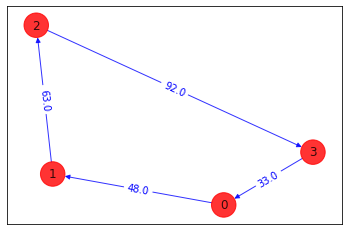

In [8]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver(qubitOp)
result = ee.run()

print('energy:', result.eigenvalue.real)
print('tsp objective:', result.eigenvalue.real + offset)
x = sample_most_likely(result.eigenstate)
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)

In [9]:
aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

/opt/conda/lib/python3.8/site-packages/qiskit/aqua/quantum_instance.py:135: DeprecationWarning: The class qiskit.aqua.QuantumInstance is deprecated. It was moved/refactored to qiskit.utils.QuantumInstance (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_class('aqua.QuantumInstance',


/opt/conda/lib/python3.8/site-packages/qiskit/aqua/components/optimizers/optimizer.py:49: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.components.optimizers',
/opt/conda/lib/python3.8/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:70: DeprecationWarning: The class qiskit.aqua.algorithms.VQAlgorithm is deprecated. It was moved/refactored to qiskit.algorithms.VariationalAlgorithm (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_class('aqua.algorithms.VQAlgorithm',


energy: -1352911.2392578125
time: 3267.594801902771
feasible: True
solution: [2, 3, 0, 1]
solution objective: 236.0


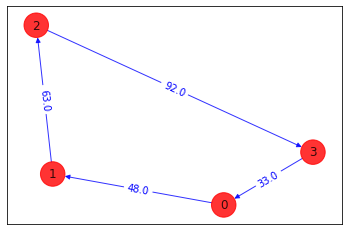

In [10]:
#spsa is the optimizer used and ry is the ansatz
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=7, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa, quantum_instance=quantum_instance)

result = vqe.run(quantum_instance)

print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
x = sample_most_likely(result.eigenstate)
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)

In [12]:
#qasm simulator is used as the backend
aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

optimal function value: 258.0
optimal value: [0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
status: SUCCESS
solution: [2, 3, 0, 1]
solution objective: 236.0


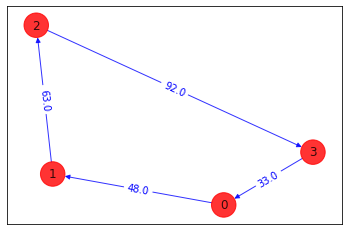

In [13]:
# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result)

z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)